In [99]:
#load libraries and environments
import spacy
from nltk.corpus import gutenberg
from spacy import displacy
import json
import os
import time
import re
import pandas as pd
import sklearn as sk
import random
#ML stuff
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn import svm
import keras

import plac
import random
import pathlib
#import cytoolz
import numpy
from keras.models import Sequential, model_from_json
from keras.layers import LSTM, Dense, Embedding, Bidirectional
from keras.layers import TimeDistributed
from keras.optimizers import Adam
#import thinc.extra.datasets
#from spacy.compat import pickle
#import spacy
from scipy.stats import mode 

In [33]:
###global variable declarations###
#for lstm models
nlp_vecs = spacy.load("en_vectors_web_lg")

#for rule 1
#----
nlp = spacy.load("en_core_web_lg")


#for rule 2
#----
# Define the keywords that will be used to extract the imperative sentences
# Rules are identified from the paper - https://www.aclweb.org/anthology/W14-2117.pdf
# 1. "find those sentences with a verb (in its base form) as the root 
#     in the phrase structure and this particular verb has no 
#.    subject child in the dependency structure" 
#.    Example: You must first discuss the matter there, and you need to be specific”
# 2. "recognize the use of a personal pronoun or noun (e.g., “you”, “we”,
#.     or a username) followed by a modal verb (e.g., “should”, “must”, “need”) as an imperative"


# Source: https://www.myenglishpages.com/site_php_files/grammar-lesson-modals.php
modal_verbs = ['can', 'could', 'may', 'might', 'will', 'would', 'shall','should', 'must', 'ought', 'dare', 'had better', 'ask']
modal_verbs = ['can', 'may', 'might', 'will', 'would', 'shall','should', 'must', 'ought', 'dare', 'had better', 'ask']

# Source: https://grammar.yourdictionary.com/parts-of-speech/pronouns/list-of-personal-pronouns.html
# personal_pronoun = ['I', 'me', 'we', 'us', 'you', 'he', 'she', 'her', 'him', 'it', 'they', 'them']
personal_pronoun = ['us', 'you', 'he', 'she', 'her', 'him', 'it', 'they', 'them']

# Create combinations of possibilities for a sentence to be imperative
combinations = []
# form combinations of words and put them as a list
for pronoun in personal_pronoun:
    for verb in modal_verbs:
        combinations.append(pronoun + ' ' + verb)
        
print('Number of combinations for rule 2 =', len(combinations))

Number of combinations for rule 2 = 108


In [34]:
# rule 1: Has a verb in its lemma (base) form and is the root and does not have any subject child in it's dependency structure
def rule1(sent):
    doc = nlp(sent)
    cond1 = False
    cond2 = True
    for token in doc:
        if token.dep_=='ROOT' and token.pos_=='VERB' and token.text.lower() == token.lemma_:
            cond1 = True
            #print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop)
        if token.dep_ == 'nsubj':
            cond2 = False   
    return (cond1 and cond2)

In [35]:
# rule 2:
def rule2(sentence):
    if any(combo in sentence.lower() for combo in combinations):
        return True
    return False

In [36]:
def rule_model(rset, sentences):
    predictions = []
    for sent in sentences:
        predicates = []
        for rule in rset:
            predicates.append(rule(sent))
        if sum(predicates)>0:
            predictions.append(1)#imperative
        else:
            predictions.append(0)#non imperative
    return predictions

In [37]:
#load kevins dataset
def load_data_kevin():
    imp_sents = []
    nimp_sents = []
    for fname in os.listdir("../data/kevin"):
        if "data" in fname:
            #print ("../data/kevin/"+fname)
            f = open("../data/kevin/"+fname, "r")
            for line in f.readlines():
                dline = line.strip().split("\t")
                if int(dline[0])==2:
                    imp_sents.append(dline[1])
                else:
                    nimp_sents.append(dline[1])
    
    neg_samples = random.sample(nimp_sents, len(imp_sents))
    neg_labels = [0]*len(neg_samples)
    pos_samples = imp_sents
    pos_labels = [1]*len(pos_samples)
    
    all_samples = neg_samples+pos_samples
    all_labels = neg_labels+pos_labels
    
    all_df = pd.DataFrame({'labels': all_labels, 'sentences': all_samples})
    all_df.to_pickle("../data/kevin_imp_data.pkl")
    
    return all_samples, all_labels

In [38]:
def lstm_model(embeddings, shape, settings):
    model = Sequential()
    #add embedding layer
    model.add(
        Embedding(
            embeddings.shape[0],
            embeddings.shape[1],
            input_length=shape["max_length"],
            trainable=False,
            weights=[embeddings],
            mask_zero=True,
        )
    )
    
    #add time distributed dense layer
    model.add(TimeDistributed(Dense(shape["nr_hidden"], use_bias=False)))
    #add bidirectional lstm
    model.add(
        Bidirectional(
            LSTM(
                shape["nr_hidden"],
                recurrent_dropout=settings["dropout"],
                dropout=settings["dropout"],
            )
        )
    )
    
    #add classification layers and compile
    model.add(Dense(shape["nr_class"], activation="sigmoid"))
    model.compile(
        optimizer=Adam(lr=settings["lr"]),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [39]:
def get_embeddings(vocab):
    return vocab.vectors.data

In [40]:
def get_features(docs, max_length):
    #docs = list(docs)
    Xs = numpy.zeros((len(docs), max_length), dtype="int32")
    for i, doc in enumerate(docs):
        j = 0
        doc = nlp_vecs(doc)
        for token in doc:
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs

In [130]:
def major_vote_clf(*preds_arrays):
    preds = []
    for arr in zip(preds_arrays[0], preds_arrays[1], preds_arrays[2]):
        #print(arr)
        preds.append(mode(arr)[0][0])
    #print (preds)
    return preds

In [41]:
#load data
samples, labels = load_data_kevin()

In [42]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(samples, labels, test_size=0.20, random_state=42)

In [43]:
#nlp(X_train[0]).vector

In [44]:
#perform rule model based prediction
rule_preds_train = rule_model(rset = [rule1, rule2], sentences = X_train)
rule_preds_test = rule_model(rset = [rule1, rule2], sentences = X_test)

In [45]:
#perform TFIDF Classical-ML Model based prediction
text_clf_tfidf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()), ('clf', svm.SVC())])
text_clf_tfidf = text_clf_tfidf.fit(X_train, y_train)

ml_tfidf_preds_train = text_clf_tfidf.predict(X_train)
ml_tfidf_preds_test = text_clf_tfidf.predict(X_test)

In [46]:
#perform W2V Classical-ML Model based prediction
X_train_vectorized = [nlp(x).vector for x in X_train]
X_test_vectorized = [nlp(x).vector for x in X_test]
text_clf_w2v = svm.SVC().fit(X_train_vectorized, y_train)

ml_w2v_preds_train = text_clf_w2v.predict(X_train_vectorized)
ml_w2v_preds_test = text_clf_w2v.predict(X_test_vectorized)

In [63]:
#perform W2V RNN-LSTM Model based prediction
print("Loading spaCy")
nlp_vecs = spacy.load("en_vectors_web_lg")
nlp_vecs.add_pipe(nlp_vecs.create_pipe("sentencizer"))
embeddings = get_embeddings(nlp_vecs.vocab)

nr_hidden = 64
max_length = 100
dropout = 0.5
learn_rate = 0.001
batch_size=100
nb_epoch=100
    
lstm_shape = {"nr_hidden": nr_hidden, "max_length": max_length, "nr_class": 1}
lstm_settings = {"dropout": dropout, "lr": learn_rate}
text_clf_lstm = lstm_model(embeddings, lstm_shape, lstm_settings)

Loading spaCy


In [64]:
#preparing training data for lstm-nn
X_train_vectorized = get_features(X_train, lstm_shape["max_length"])
X_test_vectorized = get_features(X_test, lstm_shape["max_length"])

In [65]:
#training the model
text_clf_lstm.fit(X_train_vectorized, y_train, epochs=nb_epoch, batch_size=batch_size)

Epoch 1/100
696/696 [==============================] - 3s 5ms/step - loss: 0.6616 - accuracy: 0.6408
Epoch 2/100
696/696 [==============================] - 1s 2ms/step - loss: 0.5680 - accuracy: 0.7615
Epoch 3/100
696/696 [==============================] - 1s 2ms/step - loss: 0.4760 - accuracy: 0.8118
Epoch 4/100
696/696 [==============================] - 1s 2ms/step - loss: 0.4062 - accuracy: 0.8276
Epoch 5/100
696/696 [==============================] - 1s 2ms/step - loss: 0.3639 - accuracy: 0.8391
Epoch 6/100
696/696 [==============================] - 1s 2ms/step - loss: 0.3317 - accuracy: 0.8635
Epoch 7/100
696/696 [==============================] - 1s 2ms/step - loss: 0.2951 - accuracy: 0.8822
Epoch 8/100
696/696 [==============================] - 1s 2ms/step - loss: 0.2849 - accuracy: 0.8851
Epoch 9/100
696/696 [==============================] - 2s 2ms/step - loss: 0.2663 - accuracy: 0.8980
Epoch 10/100
696/696 [==============================] - 1s 2ms/step - loss: 0.2768 - accura

In [95]:
#predicting from lstm model
lstm_preds_train = [x[0] for x in text_clf_lstm.predict_classes(X_train_vectorized)]
lstm_preds_test = [x[0] for x in text_clf_lstm.predict_classes(X_test_vectorized)]

In [131]:
#majority voting classifier
mvote_preds_train = major_vote_clf(lstm_preds_train, rule_preds_train, ml_w2v_preds_train)
mvote_preds_test = major_vote_clf(lstm_preds_test, rule_preds_test, ml_w2v_preds_test)

In [133]:
#mvote_preds_test

In [135]:
scores_rule_imperative = [x[1] for x in sk.metrics.precision_recall_fscore_support(y_test, rule_preds_test, labels=[0,1])[:3]]
scores_rule_nonimperative = [x[0] for x in sk.metrics.precision_recall_fscore_support(y_test, rule_preds_test, labels=[0,1])[:3]]
scores_ml_tfidf_imperative = [x[1] for x in sk.metrics.precision_recall_fscore_support(y_test, ml_tfidf_preds_test, labels=[0,1])[:3]]
scores_ml_tfidf_nonimperative = [x[0] for x in sk.metrics.precision_recall_fscore_support(y_test, ml_tfidf_preds_test, labels=[0,1])[:3]]
scores_ml_w2v_imperative = [x[1] for x in sk.metrics.precision_recall_fscore_support(y_test, ml_w2v_preds_test, labels=[0,1])[:3]]
scores_ml_w2v_nonimperative = [x[0] for x in sk.metrics.precision_recall_fscore_support(y_test, ml_w2v_preds_test, labels=[0,1])[:3]]
scores_ml_lstm_imperative = [x[1] for x in sk.metrics.precision_recall_fscore_support(y_test, lstm_preds_test, labels=[0,1])[:3]]
scores_ml_lstm_nonimperative = [x[0] for x in sk.metrics.precision_recall_fscore_support(y_test, lstm_preds_test, labels=[0,1])[:3]]
scores_major_vote_imperative = [x[1] for x in sk.metrics.precision_recall_fscore_support(y_test, mvote_preds_test, labels=[0,1])[:3]]
scores_major_vote_nonimperative = [x[0] for x in sk.metrics.precision_recall_fscore_support(y_test, mvote_preds_test, labels=[0,1])[:3]]

#average scores
avg_scores_rule = [x for x in sk.metrics.precision_recall_fscore_support(y_test, rule_preds_test, labels=[0,1], average='macro')[:3]]
avg_scores_ml_tfidf = [x for x in sk.metrics.precision_recall_fscore_support(y_test, ml_tfidf_preds_test, labels=[0,1], average='macro')[:3]]
avg_scores_ml_w2v = [x for x in sk.metrics.precision_recall_fscore_support(y_test, ml_w2v_preds_test, labels=[0,1], average='macro')[:3]]
avg_scores_ml_lstm = [x for x in sk.metrics.precision_recall_fscore_support(y_test, lstm_preds_test, labels=[0,1], average='macro')[:3]]
avg_scores_major_vote = [x for x in sk.metrics.precision_recall_fscore_support(y_test, mvote_preds_test, labels=[0,1], average='macro')[:3]]

In [19]:
#sk.metrics.precision_recall_fscore_support(y_test, rule_preds_test, labels=[0,1])[:3]

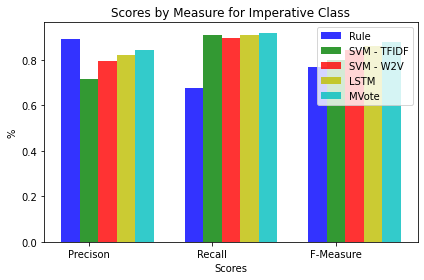

In [136]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 3
#means_frank = (90, 55, 40, 65)
#means_guido = (85, 62, 54, 20)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8

rects1 = plt.bar(index, scores_rule_imperative, bar_width,
alpha=opacity,
color='b',
label='Rule')

rects2 = plt.bar(index + bar_width, scores_ml_tfidf_imperative, bar_width,
alpha=opacity,
color='g',
label='SVM - TFIDF')

rects3 = plt.bar(index + bar_width+bar_width, scores_ml_w2v_imperative, bar_width,
alpha=opacity,
color='r',
label='SVM - W2V')

rects4 = plt.bar(index + bar_width+bar_width+bar_width, scores_ml_lstm_imperative, bar_width,
alpha=opacity,
color='y',
label='LSTM')

rects5 = plt.bar(index + bar_width+bar_width+bar_width+bar_width, scores_major_vote_imperative, bar_width,
alpha=opacity,
color='c',
label='MVote')

plt.xlabel('Scores')
plt.ylabel('%')
plt.title('Scores by Measure for Imperative Class')
plt.xticks(index + bar_width, ('Precison', 'Recall', 'F-Measure'))
plt.legend()

plt.tight_layout()
plt.show()

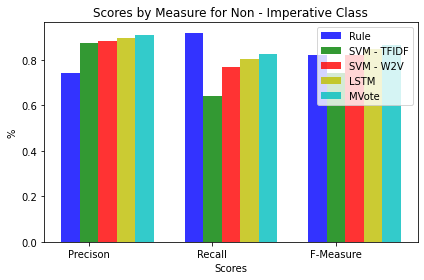

In [139]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 3
#means_frank = (90, 55, 40, 65)
#means_guido = (85, 62, 54, 20)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8

rects1 = plt.bar(index, scores_rule_nonimperative, bar_width,
alpha=opacity,
color='b',
label='Rule')

rects2 = plt.bar(index + bar_width, scores_ml_tfidf_nonimperative, bar_width,
alpha=opacity,
color='g',
label='SVM - TFIDF')

rects3 = plt.bar(index + bar_width+bar_width, scores_ml_w2v_nonimperative, bar_width,
alpha=opacity,
color='r',
label='SVM - W2V')

rects4 = plt.bar(index + bar_width+bar_width+bar_width, scores_ml_lstm_nonimperative, bar_width,
alpha=opacity,
color='y',
label='LSTM')

rects5 = plt.bar(index + bar_width+bar_width+bar_width+bar_width, scores_major_vote_nonimperative, bar_width,
alpha=opacity,
color='c',
label='MVote')

plt.xlabel('Scores')
plt.ylabel('%')
plt.title('Scores by Measure for Non - Imperative Class')
plt.xticks(index + bar_width, ('Precison', 'Recall', 'F-Measure'))
plt.legend()

plt.tight_layout()
plt.show()

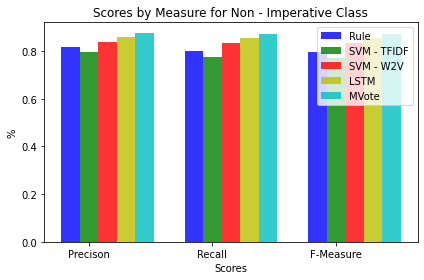

In [141]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 3
#means_frank = (90, 55, 40, 65)
#means_guido = (85, 62, 54, 20)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8

rects1 = plt.bar(index, avg_scores_rule, bar_width,
alpha=opacity,
color='b',
label='Rule')

rects2 = plt.bar(index + bar_width, avg_scores_ml_tfidf, bar_width,
alpha=opacity,
color='g',
label='SVM - TFIDF')

rects3 = plt.bar(index + bar_width+bar_width, avg_scores_ml_w2v, bar_width,
alpha=opacity,
color='r',
label='SVM - W2V')

rects4 = plt.bar(index + bar_width+bar_width+bar_width, avg_scores_ml_lstm, bar_width,
alpha=opacity,
color='y',
label='LSTM')

rects5 = plt.bar(index + bar_width+bar_width+bar_width+bar_width, avg_scores_major_vote, bar_width,
alpha=opacity,
color='c',
label='MVote')

plt.xlabel('Scores')
plt.ylabel('%')
plt.title('Scores by Measure for Non - Imperative Class')
plt.xticks(index + bar_width, ('Precison', 'Recall', 'F-Measure'))
plt.legend()

plt.tight_layout()
plt.show()

In [77]:
#sk.metrics.precision_recall_fscore_support(all_labels, preds, average='binary')

In [78]:
#pd.DataFrame(data=sk.metrics.precision_recall_fscore_support(all_labels, preds), index=['precision', 'recall', 'fscore', 'size'], columns=['Non Imperative', 'Imperative'])